In [25]:
pip install ucimlrepo

In [27]:
### Paso 1: Carga de Datos e Inspección Inicial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Cargar dataset
productivity_prediction = fetch_ucirepo(id=597)
df = pd.concat([productivity_prediction.data.features,
                productivity_prediction.data.targets], axis=1)

In [28]:
print(f"Dimensiones del dataset: {df.shape[0]} filas, {df.shape[1]} columnas\n")
print("Primeras 5 filas:")
print(df.head())
print("\nInformación de tipos de datos:")
print(df.dtypes)
print("\nResumen estadístico:")
print(df.describe(include='all'))

Dimensiones del dataset: 1197 filas, 15 columnas

Primeras 5 filas:
       date   quarter department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1     sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing  Thursday     1                   0.75   
2  1/1/2015  Quarter1     sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1     sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1     sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0      

In [29]:
### Paso 2: Validación de Calidad de Datos

# 2.1 Valores faltantes
missing_data = df.isnull().sum()
print("\nValores faltantes por columna:")
print(missing_data[missing_data > 0])



Valores faltantes por columna:
wip    506
dtype: int64


In [30]:
# 2.2 Validación de rangos
print("\nValidación de rangos:")
print(f"actual_productivity: min={df['actual_productivity'].min()}, max={df['actual_productivity'].max()} (Esperado: 0-1)")
print(f"targeted_productivity: min={df['targeted_productivity'].min()}, max={df['targeted_productivity'].max()} (Esperado: 0-1)")
print(f"incentive: min={df['incentive'].min()}, max={df['incentive'].max()} (Esperado: >=0)")
print(f"over_time: min={df['over_time'].min()}, max={df['over_time'].max()} (Esperado: >=0)")


Validación de rangos:
actual_productivity: min=0.233705476, max=1.1204375 (Esperado: 0-1)
targeted_productivity: min=0.07, max=0.8 (Esperado: 0-1)
incentive: min=0, max=3600 (Esperado: >=0)
over_time: min=0, max=25920 (Esperado: >=0)


In [31]:
# 2.3 Validación de valores únicos
print("\nValores únicos en variables categóricas:")
print(f"department: {df['department'].unique()}")
print(f"quarter: {df['quarter'].unique()}")
print(f"day: {df['day'].unique()}")


Valores únicos en variables categóricas:
department: ['sweing' 'finishing']
quarter: ['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']
day: ['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']


In [32]:
# 2.4 Identificación de duplicados
duplicates = df.duplicated().sum()
print(f"\nRegistros duplicados: {duplicates}")


Registros duplicados: 0


In [33]:
### Paso 3: Verificación de Hallazgos de los Papers
print("\n" + "="*80)
print("Paso 3: Verificación de Hallazgos de los Papers")
print("="*80)

# 3.1 Validación de valores faltantes en 'wip'
print("\nValidación Paper 1: Valores faltantes en 'wip'")
wip_missing = df['wip'].isnull()
print(f"Total valores faltantes: {wip_missing.sum()}")
if wip_missing.sum() > 0:
    print("Distribución por departamento:")
    print(df[wip_missing]['department'].value_counts())

# 3.2 Validación de distribución de clases
print("\nValidación Paper 2: Distribución de clases")
df['achievement_ratio'] = df['actual_productivity'] / df['targeted_productivity']
df['class_3cd'] = pd.cut(df['achievement_ratio'],
                        bins=[0, 0.85, 0.95, np.inf],
                        labels=['low', 'moderate', 'normal'],
                        right=False)

class_distribution = df['class_3cd'].value_counts(normalize=True) * 100
print("Distribución de clases (3 categorías):")
print(class_distribution)

# 3.3 Validación de relación incentivo-productividad
print("\nValidación Paper 3: Relación incentivo-productividad")
incentive_effect = df.groupby(pd.cut(df['incentive'], bins=[0, 69.5, 100, 200]))['achievement_ratio'].mean()
print("Efecto de incentivos en productividad:")
print(incentive_effect)



Paso 3: Verificación de Hallazgos de los Papers

Validación Paper 1: Valores faltantes en 'wip'
Total valores faltantes: 506
Distribución por departamento:
department
finishing    506
Name: count, dtype: int64

Validación Paper 2: Distribución de clases
Distribución de clases (3 categorías):
class_3cd
normal      76.524645
low         17.710944
moderate     5.764411
Name: proportion, dtype: float64

Validación Paper 3: Relación incentivo-productividad
Efecto de incentivos en productividad:
incentive
(0.0, 69.5]       1.004809
(69.5, 100.0]     1.133564
(100.0, 200.0]    1.262459
Name: achievement_ratio, dtype: float64


<ipython-input-33-caf99c0c7231>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incentive_effect = df.groupby(pd.cut(df['incentive'], bins=[0, 69.5, 100, 200]))['achievement_ratio'].mean()


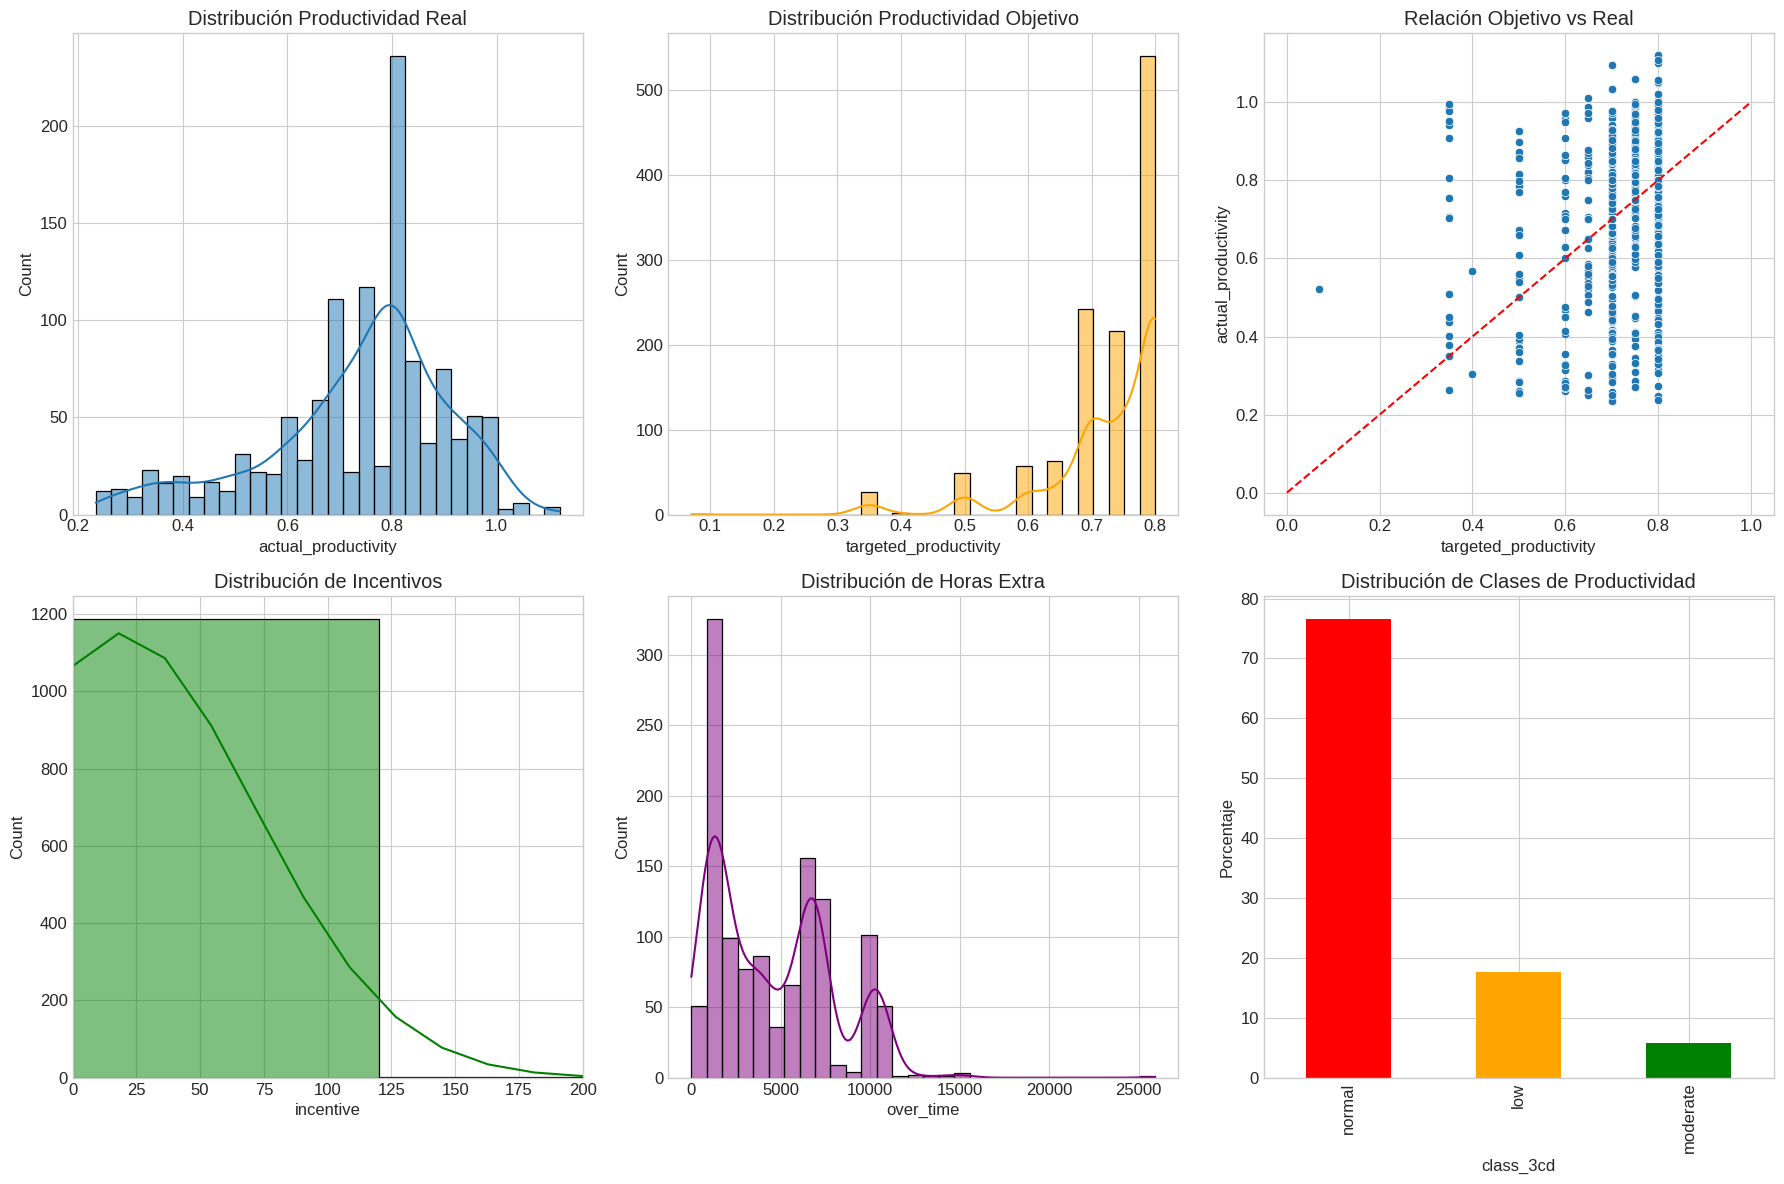

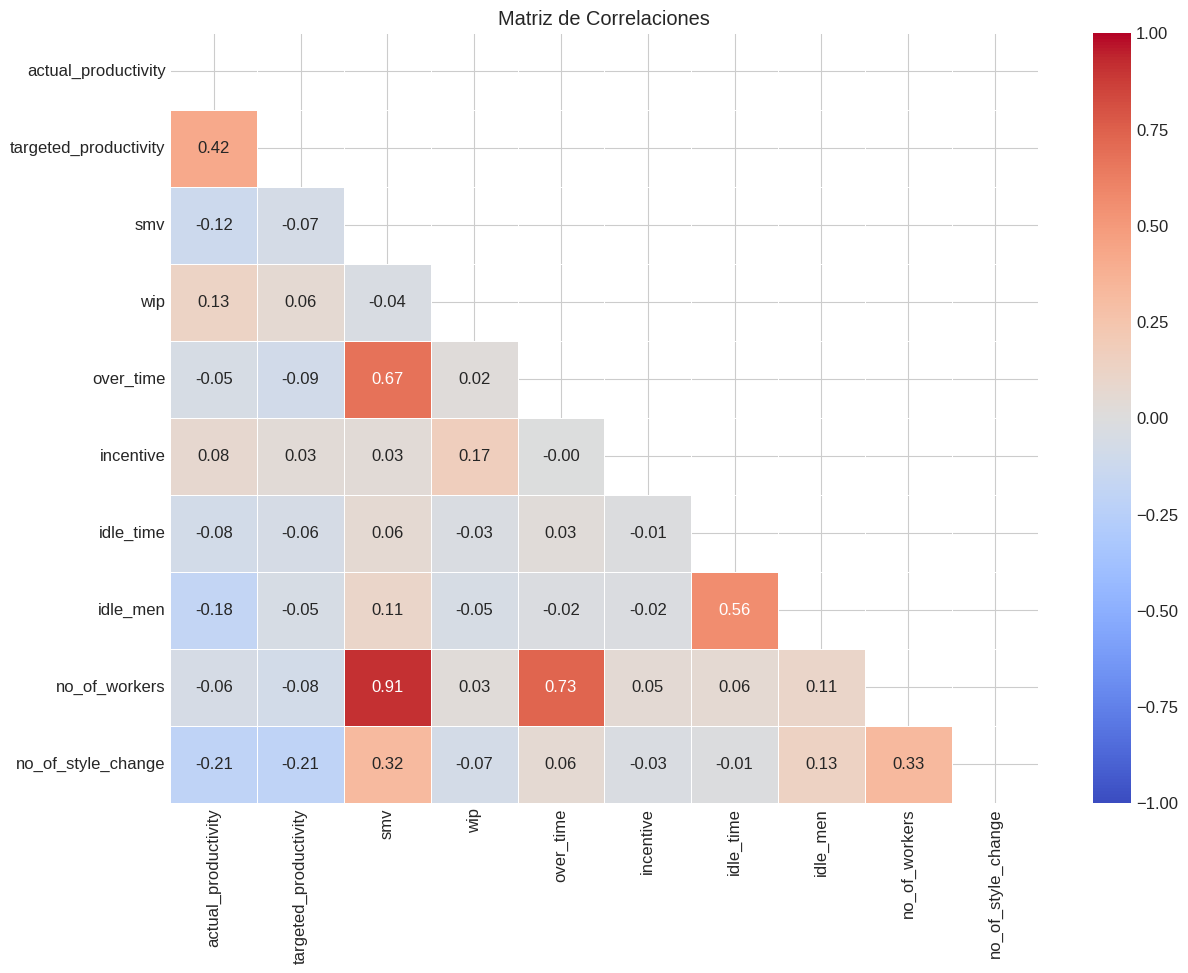

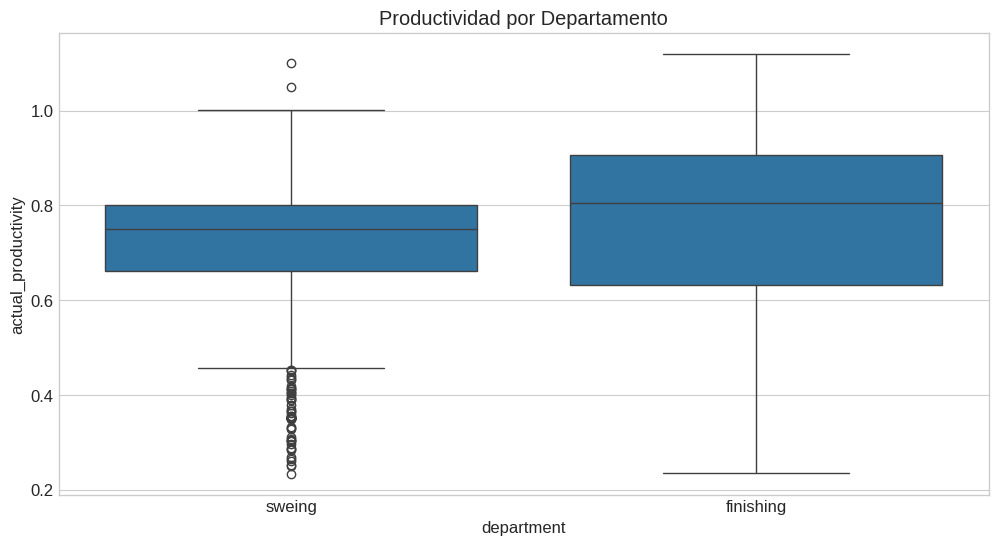

In [34]:
### Paso 4: Análisis Exploratorio Detallado (EDA)
# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12})

# 4.1 Distribución de variables clave
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Productividad
sns.histplot(df['actual_productivity'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución Productividad Real')

sns.histplot(df['targeted_productivity'], bins=30, kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Distribución Productividad Objetivo')

# Relación entre productividades
sns.scatterplot(x='targeted_productivity', y='actual_productivity', data=df, ax=axes[0, 2])
axes[0, 2].plot([0, 1], [0, 1], 'r--')
axes[0, 2].set_title('Relación Objetivo vs Real')

# Incentivos y horas extra
sns.histplot(df['incentive'], bins=30, kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Incentivos')
axes[1, 0].set_xlim(0, 200)  # Excluir outliers extremos

sns.histplot(df['over_time'], bins=30, kde=True, color='purple', ax=axes[1, 1])
axes[1, 1].set_title('Distribución de Horas Extra')

# Distribución de clases
class_distribution.plot(kind='bar', color=['red', 'orange', 'green'], ax=axes[1, 2])
axes[1, 2].set_title('Distribución de Clases de Productividad')
axes[1, 2].set_ylabel('Porcentaje')

plt.tight_layout()
plt.savefig('eda_distribuciones.png', dpi=300)
plt.show()

# 4.2 Análisis de correlaciones
numeric_cols = ['actual_productivity', 'targeted_productivity', 'smv', 'wip',
               'over_time', 'incentive', 'idle_time', 'idle_men',
               'no_of_workers', 'no_of_style_change']

plt.figure(figsize=(14, 10))
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlaciones')
plt.savefig('correlaciones.png', dpi=300)
plt.show()

# 4.3 Análisis por departamento
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='actual_productivity', data=df)
plt.title('Productividad por Departamento')
plt.savefig('productividad_departamento.png', dpi=300)
plt.show()

In [35]:
### Paso 5: Ingeniería de Características

# 5.1 Creación de nuevas características
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['workload'] = df['smv'] * df['no_of_workers']
df['incentive_per_worker'] = df['incentive'] / (df['no_of_workers'] + 1e-5)  # Evitar división por cero
df['overtime_per_worker'] = df['over_time'] / (df['no_of_workers'] + 1e-5)
df['efficiency_gap'] = df['actual_productivity'] - df['targeted_productivity']

# 5.2 Manejo de valores faltantes
print("\nManejo de valores faltantes:")
print(f"Valores faltantes antes: {df.isnull().sum().sum()}")
df['wip'] = df['wip'].fillna(0)  # Como indican los papers
print(f"Valores faltantes después: {df.isnull().sum().sum()}")

# 5.3 Creación de variable objetivo binaria
df['class_2cd'] = np.where(df['achievement_ratio'] >= 0.95, 'normal', 'low')

# 5.4 Identificación y tratamiento de outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"\nOutliers en {column}:")
    print(f"Límites: [{lower_bound:.2f}, {upper_bound:.2f}]")
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Número de outliers: {len(outliers)}")

    # Tratamiento: Winsorization
    df[column] = df[column].clip(lower_bound, upper_bound)

    return df

# Aplicar a columnas con outliers significativos
df = handle_outliers(df, 'incentive')
df = handle_outliers(df, 'over_time')
df = handle_outliers(df, 'idle_time')



Manejo de valores faltantes:
Valores faltantes antes: 506
Valores faltantes después: 0

Outliers en incentive:
Límites: [-75.00, 125.00]
Número de outliers: 11

Outliers en over_time:
Límites: [-6840.00, 15240.00]
Número de outliers: 1

Outliers en idle_time:
Límites: [0.00, 0.00]
Número de outliers: 18


In [36]:
### Paso 6: Preprocesamiento Final

# 6.1 Selección de características
features = df.drop(columns=['date', 'actual_productivity', 'achievement_ratio',
                           'class_3cd', 'class_2cd', 'team'])

# 6.2 Definición de transformaciones
numerical_features = ['targeted_productivity', 'smv', 'wip', 'over_time',
                      'incentive', 'idle_time', 'idle_men', 'no_of_workers',
                      'no_of_style_change', 'month', 'day_of_week',
                      'workload', 'incentive_per_worker', 'overtime_per_worker',
                      'efficiency_gap']

categorical_features = ['department', 'quarter', 'day']

# 6.3 División temporal de datos
print("\nDivisión temporal de datos:")
print(f"Rango fechas: {df['date'].min().date()} a {df['date'].max().date()}")
train_mask = df['date'] < '2015-03-01'
test_mask = df['date'] >= '2015-03-01'

X_train = features[train_mask]
y_train_3cd = df.loc[train_mask, 'class_3cd']
y_train_2cd = df.loc[train_mask, 'class_2cd']

X_test = features[test_mask]
y_test_3cd = df.loc[test_mask, 'class_3cd']
y_test_2cd = df.loc[test_mask, 'class_2cd']

print(f"Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(df):.1%})")
print(f"Prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(df):.1%})")

# 6.4 Procesamiento con ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ])

# Aplicar transformaciones
print("\nAplicando transformaciones...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 6.5 Verificación final
print("\nVerificación final de datos procesados:")
print(f"Formato X_train_processed: {type(X_train_processed)}, Forma: {X_train_processed.shape}")
print(f"Nombres de características: {preprocessor.get_feature_names_out()}")

# Guardar datos procesados
import joblib
joblib.dump(X_train_processed, 'X_train_processed.pkl')
joblib.dump(X_test_processed, 'X_test_processed.pkl')
joblib.dump(y_train_2cd, 'y_train_2cd.pkl')
joblib.dump(y_test_2cd, 'y_test_2cd.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

print("\nPreprocesamiento completado exitosamente!")
print("="*80)


División temporal de datos:
Rango fechas: 2015-01-01 a 2015-03-11
Entrenamiento: 985 muestras (82.3%)
Prueba: 212 muestras (17.7%)

Aplicando transformaciones...

Verificación final de datos procesados:
Formato X_train_processed: <class 'numpy.ndarray'>, Forma: (985, 25)
Nombres de características: ['num__targeted_productivity' 'num__smv' 'num__wip' 'num__over_time'
 'num__incentive' 'num__idle_time' 'num__idle_men' 'num__no_of_workers'
 'num__no_of_style_change' 'num__month' 'num__day_of_week' 'num__workload'
 'num__incentive_per_worker' 'num__overtime_per_worker'
 'num__efficiency_gap' 'cat__department_sweing' 'cat__quarter_Quarter2'
 'cat__quarter_Quarter3' 'cat__quarter_Quarter4' 'cat__quarter_Quarter5'
 'cat__day_Saturday' 'cat__day_Sunday' 'cat__day_Thursday'
 'cat__day_Tuesday' 'cat__day_Wednesday']

Preprocesamiento completado exitosamente!
